# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>

# Devoir 6 - Régression bayésienne ( 15 points )

Le devoir concerne les notions de la régression linéaire bayésienne vues au Chapitre 7 du cours. 

## Devoir effectué par

Paré, Marie-Christine - 1901114

NOM, PRÉNOM - MATRICULE

**Déclaration d’intégrité relative au plagiat**

Nous certifions sur l’honneur :
- Que les résultats décrits dans ce rapport sont l’aboutissement de notre travail.
- Que nous sommes les auteurs de ce rapport.
- Que nous n'avons pas utilisé des sources ou résultats tiers sans clairement les citer et les référencer selon les règles bibliographiques préconisées.

Nous déclarons que ce travail ne peut être soupçonné de plagiat.



# Contexte : Le valeur des diamants en fonction de leurs caractéristiques

Dans ce devoir, on s'intéresse à la valeur des diamants en fonctions de plusieurs caractéristiques phyiques. Le jeux de données contient les variables suivantes :

- Price : le prix du diamant en dollars américains
- Carat : le poids du diamant
- X : la longueur du diamant
- Y : la largeur du diamant
- Z : la profondeur du diamant
- Depth : la profondeur realtive du diamant ( z / mean(x, y) )
- Table : la largeur du sommet relativement relativement à la plus grande largeur


# Consignes

- Le devoir doit être remis sur Moodle **avant 23h59 le mardi 17 novembre 2020.** Les retards ne seront pas tolérés car le solutionnaire sera publié dès mercredi.
- Le devoir a une pondération de 7.5%.
- Écrivez vos noms et vos matricules dans l'espace prévu à cet effet de cette cellule.
- Vous pouvez compléter le devoir en équipe de deux personnes. Dans ce cas, un seul fichier par équipe doit être remis. Pour vous aider à trouver un coéquipier, le canal de discussion *#trouver_un_coéquipier* a été créé sur Slack.
- Le devoir doit être complété dans le présent calepin Jupyter en ajoutant autant de cellules de texte et de code que nécessaires. Vous remettrez ce fichier en format *.ipynb*. Le nom du fichier doit être *matricule1_matricule2_devoir2.ipynb*.
- N'utilisez que les librairies introduites à la cellule suivante.

## Chargement des librairies

In [2]:
using CSV              # Pour la manipulation des fichiers CSV
using DataFrames       # Pour l'utilisation des DataFrame
using Distributions    # Pour l'utilisation des lois de probabilités
using Gadfly           # Pour la création de figures
using LinearAlgebra    # Pour l'utilisation de fonctions d'algèbre linéaire
import Random          # Pour l'utilisation des générateurs de nombres aléatoires
using Statistics       # Pour l'utilisation de fonctions statistiques de bases  
import StatsBase       # Pour la standardisation des variables

## Chargement des données

On prend la racine cubique du prix pour linéariser la relation

In [3]:
data = CSV.read("diamondprices.csv", DataFrame)
data[!, :Price] = data[:,:Price].^(1/3)
first(data, 5)

,Price,Carat,X,Y,Z,Depth,Table
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.21303,0.24,3.95,3.92,2.45,62.3,59.0
2,14.3127,0.7,5.71,5.62,3.51,62.0,61.0
3,14.5888,0.7,5.75,5.68,3.5,61.2,56.0
4,14.6512,0.74,5.84,5.79,3.56,61.2,59.0
5,14.7881,0.7,5.68,5.62,3.55,62.8,58.0


## Partitionnement du jeu de données en ensemble d'entraînement et de validation

In [4]:
Random.seed!(3302)

ntrain = round(Int, .8*nrow(data))

train_id = sample(1:nrow(data), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]

,Price,Carat,X,Y,Z,Depth,Table
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,19.0286,1.04,6.71,6.66,3.89,58.2,60.0
2,19.4773,1.25,6.96,6.87,4.29,62.0,58.0
3,19.8725,1.0,6.39,6.32,4.0,62.9,53.0
4,20.1407,1.06,6.53,6.57,4.0,61.1,58.0
5,20.6986,1.13,6.87,6.79,4.05,59.3,59.0
6,25.2529,1.52,7.48,7.38,4.49,60.4,59.0
7,9.34466,0.31,4.34,4.39,2.71,62.1,59.0
8,9.53908,0.33,4.43,4.47,2.71,60.9,58.0
9,9.8132,0.3,4.26,4.21,2.65,62.6,62.0


## Standardisation des variables de l'ensemble d'entraînement

Une fois les variables standardisées, l'ordonnée à l'origine n'est plus nécessaire.

In [55]:
# Estimation des paramètres de la standardisation
ty = StatsBase.fit(StatsBase.ZScoreTransform, train.Price)

# Standardisation des variables
y = StatsBase.transform(ty, train.Price)

# Estimation des paramètres de la standardisation
tx = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(train[:,2:end]), dims=1)

# Standardisation des variables
X = StatsBase.transform(tx, Matrix{Float64}(train[:,2:end]));

# Exercice 1 : Loi *a priori* non informative

### (a) Y a-t-il présence de multicolinéarité ? ( 3 points )

Si les 6 variables explicatives (:Carat, :X, :Y, :Z, :Depth, :Table) sont utilisées pour prédire la valeur des diamants (:Price), y a-t-il présence de multicolinéarité ?

Justifiez votre réponse.

In [135]:
n=length(y)
m = size(X,2)
β̂₀ = (X'X)\X'y

println("β̂ = ", β̂₀)


#Caluler R²

function R2m(X, y,λ)
    β̂ = (X'X + λ*I)\X'y
    e = y - X*β̂
    ȳ = mean(y)
    SST = sum( (y[i] - ȳ)^2 for i=1:n )
    SSE = e'e
    R² = 1 - SSE/SST
    return R²
end 

#Calcul du VIF
function VIF(x1, X_1, λ)
    R2 = R2m(X_1, x1,λ)
    VIF = 1/(1-R2)
    return VIF
end

vars=[train.Carat,train.X,train.Y,train.Z,train.Depth,train.Table]
VIF_mat=Matrix(undef,6, 5)

for i in 1:6
    Xᵢ=hcat(ones(n), vars[i])
    for j in 1:6
        if j != i
            xⱼ= vars[j]
            VIF_ij=VIF(xⱼ,Xᵢ,0)
            println("$i, $j, $VIF_ij")
            #push!(VIF_mat[i,j],VIF_ij)
        end
    end
end


β̂ = [0.9505520342724629, 0.8416941255455307, -0.7619261033700765, -0.033895555998256374, 0.020285498007509967, 0.008912947349778138]
1, 2, 42.10426623265032
1, 3, 49.706140969585924
1, 4, 54.36220622057443
1, 5, 1.0078033749112054
1, 6, 1.0004597867178082
2, 1, 42.10426623265052
2, 3, 391.52339157992697
2, 4, 101.0725790866833
2, 5, 1.0238508231661552
2, 6, 1.0010294573037837
3, 1, 49.706140969586194
3, 2, 391.52339157992697
3, 4, 104.60534816171975
3, 5, 1.0235806214424021
3, 6, 1.000737997619837
4, 1, 54.362206220574755
4, 2, 101.0725790866833
4, 3, 104.60534816171975
4, 5, 1.0035085439556932
4, 6, 1.003211669049726
5, 1, 1.0078033749112094
5, 2, 1.0238508231661572
5, 3, 1.0235806214424037
5, 4, 1.0035085439556934
5, 6, 1.0785658352487637
6, 1, 1.0004597867178124
6, 2, 1.0010294573037861
6, 3, 1.0007379976198378
6, 4, 1.0032116690497264
6, 5, 1.0785658352487637


### (b) Calculez un intervalle de crédibilité pour le coeffifient correspondant aux poids (:Carats) (2 points).

Calculez cet intervalle lorsque les 6 variables explicatives sont utilisées pour prédire la valeur des diamants. Utilisez le seuil de α = 5%.

In [57]:
#Calculez les intervalles de confiance à 95 % pour β
p=6
e = y - X*β̂₀
SSE = e'e
σ̂²  = SSE/(n-p-1)
V = inv(X'X)
q = quantile(TDist(n-p-1),.975)
se = q * sqrt.(σ̂² * diag(V))
a = round.(β̂ - se, digits=3)
b = round.(β̂ + se, digits=3)

println("β̂_$(1) ∈ [$(a[1]) , $(b[1])]")


β̂_1 ∈ [0.583 , 0.904]


### (c) Déterminez si le poids (en carats) a un pouvoir prédictif significatif sur le prix des diamants (2 points).

Utilisez le seuil de α = 5%. Prenez en compte votre réponse de 1 (a).

# Exercice 2 : Régression ridge

Utilisez les six variables explicatives pour modéliser la valeur des diamants mais, cette fois-ci, en utilisant le modèle de la régression ridge.

### (a) Spécifier l'hyperparamètre λ en minimisant le rmse sur l'échantillon de validation (3 points).


In [35]:
#Ensemble de validation 
# Standardisation des variables 

X_valid = StatsBase.transform(tx, Matrix{Float64}(valid[:,2:end]));
y_valid= StatsBase.transform(ty, valid.Price)


34-element Array{Float64,1}:
  1.3620244788172398
  1.4584063044572748
  1.5433010701560068
  1.6008995536780872
  1.7207499883134496
  2.6989932582235685
 -0.7180592455884446
 -0.6762973504643982
 -0.617417654208371
 -0.5938889387640288
 -0.5888107496817654
 -0.5680253786501466
 -0.5680253786501466
  ⋮
 -0.4926087870939522
 -0.47616255060290186
 -0.456097516097021
 -0.4427041173529027
 -0.4427041173529027
 -0.43827439820773445
 -0.4207248328891189
 -0.40282593913527137
 -0.9858900893326066
  0.012222903332226823
  0.048332555800352055
  0.08352569463236215

λ̂=0.0438


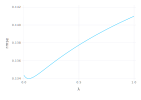

In [143]:
df = DataFrame(λ = Float64[], rmse = Float64[])

for λ in 0:.0001:1

    β̂ = (X'X + λ*I)\X'y
    
    ŷ = X_valid*β̂
    
    rmse = StatsBase.rmsd(ŷ, y_valid)
    
    push!(df, [λ, rmse])
    
end

λ̂ = df.λ[argmin(df.rmse)]
println("λ̂=",λ̂)
plot(df, x=:λ, y=:rmse, Geom.line)

### (b) Comparer les estimations ridges avec les estimations classiques que vous auriez obtenues avec la méthode des moindres carrés (3 points)

Par exemple : Quelles variables sont les plus importantes ? Est-ce que les effets des variables changent ? Si oui, pourquoi ? Etc.

In [147]:
#println(β̂₀)
# Régression de Ridge 
β̂λ= (X'X + λ̂*I)\X'y
#println(β̂λ)

coefnamesλ = ["βλ₁", "βλ₂", "βλ₃", "βλ₄", "βλ₅", "βλ₆"]
coefnames0 = ["β₀₁", "β₀₂", "β₀₃", "β₀₄", "β₀₅", "β₀₆"]
dfβ̂λ=DataFrame(coef=coefnamesλ,β̂λ=β̂λ)
sort!(dfβ̂λ,:β̂λ,rev=true)
dfβ̂₀=DataFrame(coef=coefnames0,β̂₀=β̂₀)
sort!(dfβ̂₀,:β̂₀,rev=true)
data_sorted=DataFrame(coef_β̂λ=dfβ̂λ.coef,β̂λ=dfβ̂λ.β̂λ,coef_β̂₀=dfβ̂₀.coef,β̂₀=dfβ̂₀.β̂₀)

for i in 1:6
    if data_sorted.β̂λ[i] > data_sorted.β̂₀[i]
        println(data_sorted.coef_β̂λ[i]," > ",data_sorted.coef_β̂₀[i])
    end 
    
    if data_sorted.β̂λ[i] < data_sorted.β̂₀[i]
        println(data_sorted.coef_β̂λ[i]," < ",data_sorted.coef_β̂₀[i])
    end 
end 


#println(R2m(X[:,1:2], y,λ̂))
#println(R2m(X[:,1:2], y,0))




βλ₁ < β₀₁
βλ₂ < β₀₂
βλ₅ > β₀₅
βλ₆ < β₀₆
βλ₄ > β₀₄
βλ₃ > β₀₃


### (c) Calculez un intervalle de crédibilité pour le coefficient de régression associé à la profondeur (:Z) (1 point).

Utilisez le seuil de α = 5%.

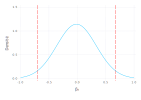

In [177]:
β̂ = (X'X + λ̂*I)\X'y

s² = (y'y - β̂'*(X'X + λ̂*I)*β̂)/n

Σ = s²*inv(X'X + λ̂*I)

pd = LocationScale(β̂[4],sqrt(Σ[4,4]),TDist(n-m))

plot(x->pdf(pd,x), -1, 1,
    xintercept = quantile.(pd, [.025, .975]), Geom.vline(style=:dash, color="red"),
    Guide.xlabel("β₄"), Guide.ylabel("Densité"))




In [175]:
println("β̂₄=",β̂[4])
println("L'intervalle de confiance est : ")
println(quantile.(pd, [.025, .975]))


β̂₄=-0.014480042108670143
L'intervalle de confiance est : 
[-0.7041362346167351, 0.6751761503993947]


### (d) Déterminez si la profondeur possède une influence significative sur la valeur des diamants (1 point).

Prenez en compte le fait qu'il y ait multicolinéarité ou pas. Utilisez le seuil de α = 5%.

In [190]:
pd = LocationScale(β̂[5],sqrt(Σ[5,5]),TDist(n-m))
println(β̂[5])
println(quantile.(pd, [.025, .975]))

0.020501870588821535
[-0.04803289571347605, 0.08903663689111913]
